In [2]:
# Imports:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

Exercise 1

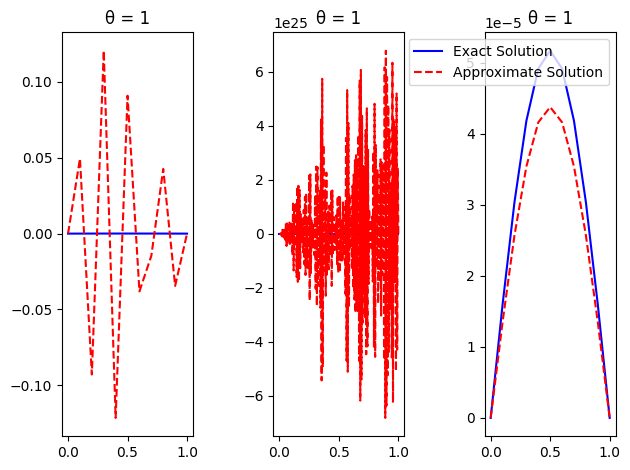

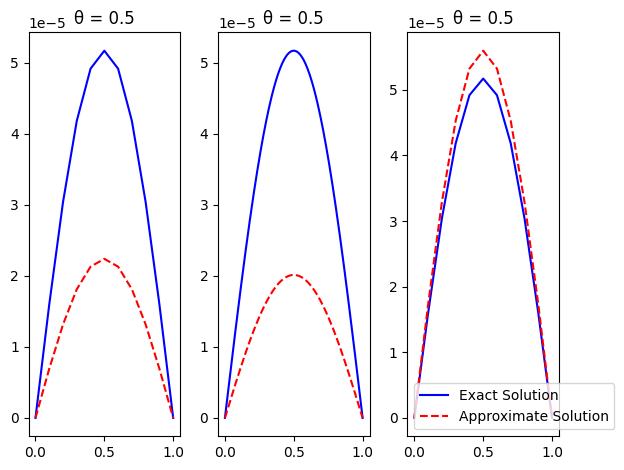

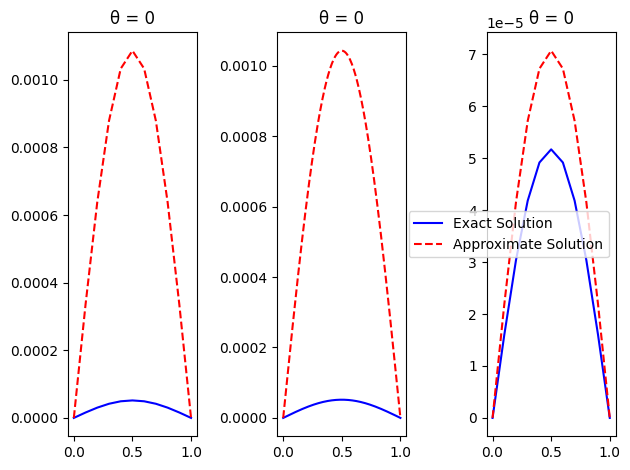

In [3]:
# Uniform partitioning of (0,1) into N subintervals
# Most of these parts are from the second lab exercise
# or written for this lab with ChatGPT support.
def MassMatrix(N):
    
    n = N + 1
    h = 1/N
    M = np.zeros((n,n))
    M[0][0] = h/2
    M[-1][-1] = h/2

    for i in range(1,n-1):
        M[i][i] = h

    return M

def ApplyIC(g, x):
    return np.array([g(xi) for xi in x])

def g(x):
    return np.sin(np.pi * x)

def exact_solution(x,t):
    return np.exp(-np.pi**2 * t) * np.sin(np.pi * x)

def Test_c(x):
    return 1


def StiffnessMatrix(N,c = Test_c):
    A_matrix = np.zeros((N+1, N+1))
    h = 1/N
    xi = 0
    xi_next = h

    A_matrix[0][0] = (c(xi) + c(xi_next))/(2*h)
    A_matrix[0][1] = -(c(xi) + c(xi_next))/(2*h) 
    
    for i in range(1,N):
        xi_prev = xi
        xi = xi_next
        xi_next += h
        
        A_matrix[i][i-1] = -(c(xi_prev) + c(xi))/(2*h)
        A_matrix[i][i] = (c(xi_prev) + 2*c(xi)+ c(xi_next))/(2*h)
        A_matrix[i][i+1] = -(c(xi) + c(xi_next))/(2*h)

    A_matrix[-1][-2] = -(c(1-h) + c(h))/(2*h)
    A_matrix[-1][-1] = (c(1-h) + c(h))/(2*h)


    return A_matrix


def LoadVector(N, f,t,qb=0):
    b_vector = np.zeros(N+1)
    h = 1/N
    xi = 0
    
    b_vector[0] = h/2*f(xi,t)

    for i in range(1,N):
        xi += h
        b_vector[i] = h*f(xi,t)

    b_vector[-1] = h/2*f(xi+h,t) + qb

    return b_vector


def FEM_HeatEq_1D(theta, M, N,exercise = 1 ):
    h = 1 / N
    k = 1 / M
    x = np.linspace(0, 1, N + 1)
    t = np.linspace(0, 1, M + 1)
    
    U = np.zeros((N + 1, M + 1))
    U[:, 0] = ApplyIC(g, x)
    
    mass_matrix = MassMatrix(N)
    stiffness_matrix = StiffnessMatrix(N)

    def f(x,t):
        return 0 
    
    for l in range(M):
        A_tl = stiffness_matrix
        b_tl = LoadVector(N,f,t[l])
        
        A_tl[0, 0] = A_tl[-1, -1] = 1
        A_tl[0, 1] = A_tl[-1, -2] = 0
        b_tl[0] = b_tl[-1] = 0

        A_tl_next = A_tl
        b_tl_next = b_tl

        
        A_tilde = mass_matrix + (1 - theta) * k * A_tl_next
        b_tilde = np.dot(mass_matrix - theta * k * A_tl, U[:, l]) + k * (theta * b_tl + (1 - theta) * b_tl_next)

        if exercise == 2:
            b_tilde[-1] += 1 - np.exp(-3 * t[l+1])
            A_tilde[-1, :] = 0
            A_tilde[-1, -1] = 1
        
        U[:, l + 1] = np.linalg.solve(A_tilde, b_tilde)
    
    return x, t, U

def plot_results(p1,p2,p3,theta):
    
    plt.subplot(1, 3, 1)
    plt.plot(p1[0], exact_solution(p1[0], 1), label='Exact Solution', color='blue')
    plt.plot(p1[0], p1[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'θ = {theta}')

    plt.subplot(1, 3, 2)
    plt.plot(p2[0], exact_solution(p2[0], 1), label='Exact Solution', color='blue')
    plt.plot(p2[0], p2[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'θ = {theta}')

    plt.subplot(1, 3, 3)
    plt.plot(p3[0], exact_solution(p3[0], 1), label='Exact Solution', color='blue')
    plt.plot(p3[0], p3[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'θ = {theta}')

    plt.legend()    
    plt.tight_layout()
    plt.show()

# parameters mentioned in lab 4 notes exercise 1/c
params = [(1, 10, 10), (1, 10, 200), (1, 200, 10),
          (0.5, 10, 10), (0.5, 10, 200), (0.5, 200, 10),
          (0, 10, 10), (0, 10, 200), (0, 200, 10)]



for i in range(0,3):
    theta1, M1, N1 = params[i*3]
    theta2, M2, N2 = params[i*3+1]
    theta3, M3, N3 = params[i*3+2]
    
    params1 = FEM_HeatEq_1D(theta1, M1, N1)
    params2 = FEM_HeatEq_1D(theta2, M2, N2)
    params3 = FEM_HeatEq_1D(theta3, M3, N3)

    plot_results(params1, params2, params3,theta1)





In [ ]:
# Which theta values of theta, N, M are the approximations of?

'''
Parameters are refered in a form of: (theta, M, N)
For the cases where we have (theta,10, 10), (theta, 10, 200) parameters, where theta value does not matter,
neither of the approxiamtion seems to be correct, or at least they do not have a sufficiantly great approximation.

For estimations, where we have (theta, 200, 10), it seems we get great approximations.

As it is mentioned in the lab notes, θ = 1 results in a forward Euler scheme. In in the funciton FEM_HeatEq_1D()
in the for loop when calculating b_tilde, with θ = 1, b_tl_next is not considered. With small M, the iteration for this
vector is not enough. for big N with small M, the iteration is still too small. Also theta = 1 is not A - stable.

For other θ = 0 (backward Euler) and θ = 1/2 (Crank - Nicolson) theta values the calcualtions
seem to be correct, but N and M values limit the calculations precision.
'''


'\nParameters are refered in a form of: (theta, M, N)\nFor the cases where we have (theta,10, 10), (theta, 10, 200) parameters, where theta value does not matter,\nneither of the approxiamtion seems to be correct, or at least they do not have a sufficiantly great approximation.\n\nFor estimations, where we have (theta, 200, 10), it seems we get great approximations.\n\nAs it is mentioned in the lab notes, θ = 1 results in a forward Euler scheme. In in the funciton FEM_HeatEq_1D()\nin the for loop when calculating b_tilde, with θ = 1, b_tl_next is not considered. With small M, the iteration for this\nvector is not enough. for big N with small M, the iteration is still too small.\n\nFor other θ = 0 (backward Euler) and θ = 1/2 (Crank - Nicolson) theta values the calcualtions\nseem to be correct, but N and M values limit the calculations precision.\n'

Exercise 2


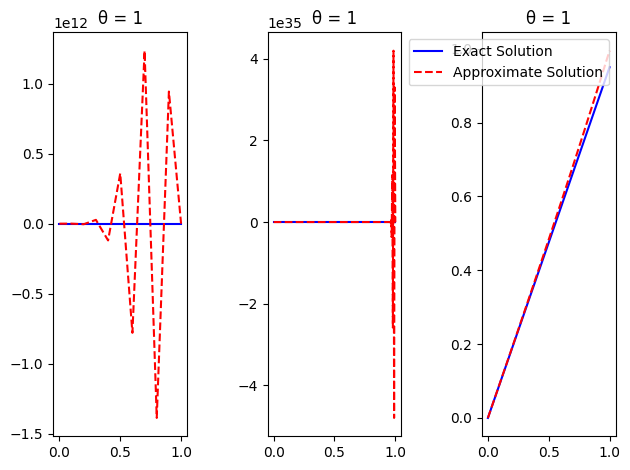

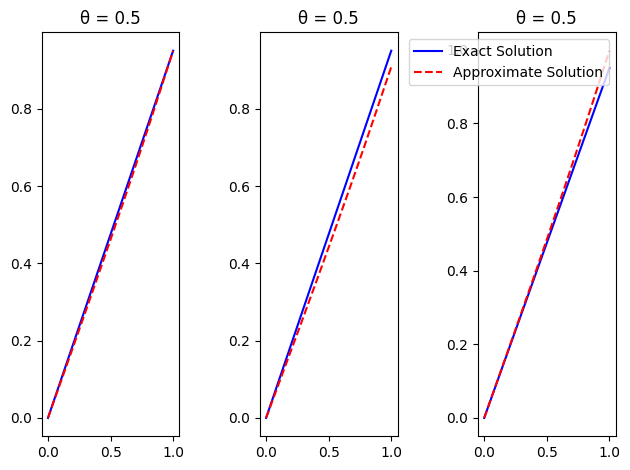

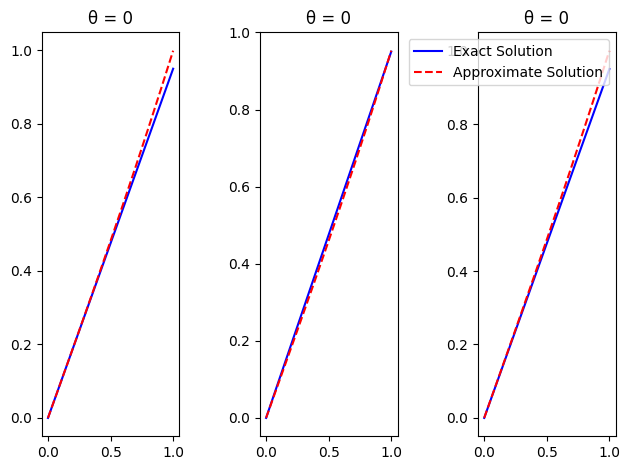

In [4]:
# Exact solution for exercise 2:
def g(x):
    return 0

def f(x,t):
    return 3*x*np.exp(-3*t)

def exact_solution(x,t):
    return x*(1-np.exp(-3*t))

# Same for loop for different thetas as before:
for i in range(0,3):
    theta1, M1, N1 = params[i*3]
    theta2, M2, N2 = params[i*3+1]
    theta3, M3, N3 = params[i*3+2]
    
    params1 = FEM_HeatEq_1D(theta1, M1, N1,2)
    params2 = FEM_HeatEq_1D(theta2, M2, N2,2)
    params3 = FEM_HeatEq_1D(theta3, M3, N3,2)

    plot_results(params1, params2, params3,theta1)


Exercise 2/b)

In [5]:
N = 4
# Theta is 0.5 or 0 corresponding to Crank-Nicolson and backward Euler methods.
# As only the time discretisation contributes to the error, in the equation mentioned in lab notes 3 in eq (6) we can neglect C1 part of the term.



# This is for calculating error norm, I have used this in my lab 2 solution.
def Errornorm(U,x):
    
    # we only take the last time instance for comparison:
    sol = exact_solution(exact_solution(x, 1),1)
    approx = U[:, -1]

    e =  abs( np.linalg.norm(sol,2) - np.linalg.norm(approx,2))
    return e

# --------------------------------------------------------------------------
# This aprt is for theta = 0.5:

M = [4,8,16,64,128,256]

rates = np.zeros(len(M))
errors = np.zeros(len(M))

for i in range(0,len(M)-1):
    
    xt,t,U_t  = FEM_HeatEq_1D(0.5, M[i], N,2)
    xt2,t2,U_2t = FEM_HeatEq_1D(0.5, M[i+1], N,2)

    dif_t  = Errornorm(U_t,xt) 
    dif_2t = Errornorm(U_2t,xt2)
    
    r = np.log2(dif_2t/dif_t)

    errors[i] = dif_t
    rates[i] = r


# The error is quite consistent in this range.
print('For theta = 0.5 the results are: ')
print(tabulate([['errors', errors[0], errors[1],errors[2],errors[3],errors[4]], ['rates', rates[0], rates[1],rates[2],rates[3],rates[4]]], headers= ['M',M[0], M[1],M[2],M[3],M[4],],tablefmt="grid"))

# --------------------------------------------------------------------------
# This aprt is for theta =0:


M = [4,8,16,64,128,256]

rates = np.zeros(len(M))
errors = np.zeros(len(M))

for i in range(0,len(M)-1):
    
    xt,t,U_t  = FEM_HeatEq_1D(0, M[i], N,2)
    xt2,t2,U_2t = FEM_HeatEq_1D(0, M[i+1], N,2)

    dif_t  = Errornorm(U_t,xt) 
    dif_2t = Errornorm(U_2t,xt2)
    
    r = np.log2(dif_2t/dif_t)

    errors[i] = dif_t
    rates[i] = r

print('For theta = 0 the results are: ')
print(tabulate([['errors', errors[0], errors[1],errors[2],errors[3],errors[4]], ['rates', rates[0], rates[1],rates[2],rates[3],rates[4]]], headers= ['M',M[0], M[1],M[2],M[3],M[4],],tablefmt="grid"))

For theta = 0.5 the results are: 
+--------+-----------+----------+----------+-----------+-----------+
| M      |         4 |        8 |       16 |        64 |       128 |
+========+===========+==========+==========+===========+===========+
| errors | 0.0541517 | 0.135316 | 0.183283 | 0.22233   | 0.229098  |
+--------+-----------+----------+----------+-----------+-----------+
| rates  | 1.32125   | 0.437745 | 0.278624 | 0.0432674 | 0.0213324 |
+--------+-----------+----------+----------+-----------+-----------+
For theta = 0 the results are: 
+--------+----------+-----------+-----------+------------+------------+
| M      |        4 |         8 |        16 |         64 |        128 |
+========+==========+===========+===========+============+============+
| errors | 0.209021 | 0.225037  | 0.231037  | 0.234811   | 0.235385   |
+--------+----------+-----------+-----------+------------+------------+
| rates  | 0.106514 | 0.0379651 | 0.0233766 | 0.00351844 | 0.00172091 |
+--------+---------

Exercise 3)

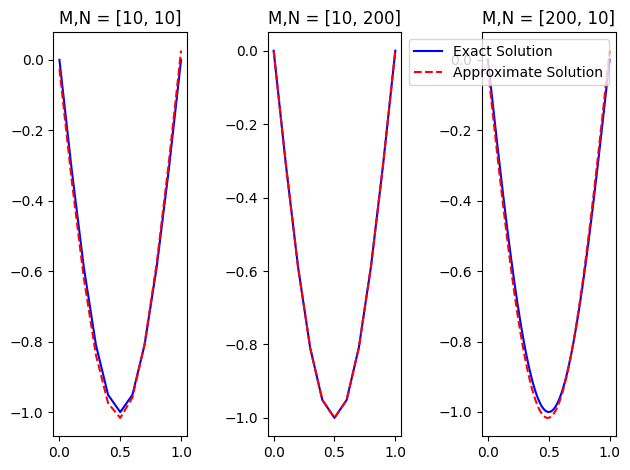

In [6]:
# This is the solution for wave equation,
# created with ChatGPT support. For the final version
# I chose not to include my BoundaryCondition() function, as
# using it gave worse results and I was not able to resolve it.
# The implementation of it is included, but it is commented out.

def BoundaryCondition(U,t):
    U_ = U
    U_[0] = np.pi * np.cos(np.pi * t)
    U_[-1] = np.pi * np.cos(np.pi - np.pi * t)
    return U_

def exact_solution(x, t):
    return np.sin(np.pi * x - np.pi * t)

def FEM_Wave(N,M):
    h = 1 / N 
    k = 1 / M  
    
    x = np.linspace(0, 1, N+1)
    t = np.linspace(0, 1, M+1)

    # Initialization:
    u0 = np.sin(np.pi * x)
    v0 = -np.pi * np.cos(np.pi * x)
    
    U = np.zeros((N+1, M+1))
    U[:, 0] = u0

    # This is where I apply ERK method:
    for l in range(M):

        u_half = U[:, l] + 0.5 * k * v0
        v_half = v0 + 0.5 * k * (-np.pi**2 * np.sin(np.pi * x))
        
        U[:, l+1] = U[:, l] + k * v_half
        v0 = v0 + k * (-np.pi**2 * np.sin(np.pi * (x - (l+1) * k)))

        # This part is included, but I chose to comment
        # it out for the final run:
        # U = BoundaryCondition(U,t[l])

    return x,t,U

# I have redefined this function, because we don't need theta:
def plot_results(p1,p2,p3):
    plt.subplot(1, 3, 1)
    plt.plot(p1[0], exact_solution(p1[0], 1), label='Exact Solution', color='blue')
    plt.plot(p1[0], p1[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'M,N = {[10,10]}')

    plt.subplot(1, 3, 2)
    plt.plot(p2[0], exact_solution(p2[0], 1), label='Exact Solution', color='blue')
    plt.plot(p2[0], p2[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'M,N = {[10,200]}')

    plt.subplot(1, 3, 3)
    plt.plot(p3[0], exact_solution(p3[0], 1), label='Exact Solution', color='blue')
    plt.plot(p3[0], p3[2][:, -1], '--', label='Approximate Solution', color='red')
    plt.title(f'M,N = {[200,10]}')

    plt.legend()    
    plt.tight_layout()
    plt.show()


# Parameters given in Exercise 1:
# Initial values for constructing the initial vectors.
M1, N1 = (10,10)
M2, N2 = (10,200)
M3, N3 = (200,10)
    
params1 = FEM_Wave(M1, N1)
params2 = FEM_Wave(M2, N2)
params3 = FEM_Wave(M3, N3)

plot_results(params1, params2, params3)